#Trabalho 2 de Mineração de Dados: Imputando Valores

<b> Integrantes do Grupo: </b><br>
 - Murilo Dias <br>
 - Vinicius Lucena <br>
 - Vinicius Pinheiro <br>

#1. Formação de Base de dados com valores faltantes:

##1.1. Import de Biblioteca:

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
import plotly.express as px


##1.2. Procassamento de base de dados e remoção de componentes:

In [ ]:
#Carregando base de dados
penguins = sns.load_dataset('penguins')

np.random.seed(42)  #Definindo seed do random para replicabilidade

#Removendo valores
removidos = set()
porcentagem = 0.30 #Porcentagem (0~1) das células a serem removidas
qtdCelulas = len(penguins)*(len(penguins.columns)) #Quantidade de células na base de dados, ignorando a última coluna

for i in range(int(np.ceil(porcentagem*qtdCelulas))):
  linha = np.random.randint(0, len(penguins))
  coluna = np.random.randint(0, len(penguins.columns))
  while (linha, coluna) in removidos:
    linha = np.random.randint(0, len(penguins))
    coluna = np.random.randint(0, len(penguins.columns))

  penguins.iloc[linha, coluna] = np.nan
  removidos.add((linha,coluna))

penguins.info()
print("\n\nForam removidas ",str(len(removidos)), "células das ",str(qtdCelulas))
del removidos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            232 non-null    object 
 1   island             241 non-null    object 
 2   bill_length_mm     233 non-null    float64
 3   bill_depth_mm      244 non-null    float64
 4   flipper_length_mm  247 non-null    float64
 5   body_mass_g        240 non-null    float64
 6   sex                235 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Foram removidas  723 células das  2408


#2. Estudos Iniciais: <br>
A fim de reunir informações básicas sobre quais foram os efeitos da retirada das informações.

In [ ]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,NaN,18.7,NaN,3750.0,Male
1,NaN,NaN,39.5,17.4,186.0,NaN,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,NaN,NaN,NaN,NaN,NaN,NaN
4,Adelie,NaN,NaN,19.3,193.0,3450.0,NaN
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,NaN,46.8,14.3,215.0,NaN,NaN
341,NaN,Biscoe,NaN,NaN,NaN,5750.0,NaN
342,Gentoo,Biscoe,45.2,14.8,NaN,5200.0,Female


<Axes: xlabel='species', ylabel='island'>

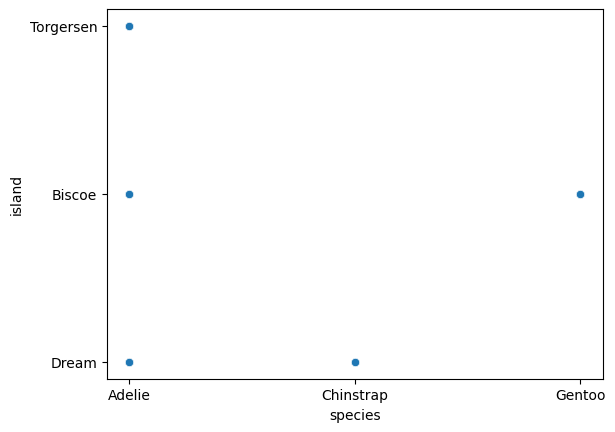

In [ ]:
sns.scatterplot(x=penguins['species'], y=penguins['island'], data=penguins)

##2.1. Separação de Categorias Categóricas e Numéricas: <br>
Por mais que vamos utilizar ambas colunas para verificar a veracidade e precisão dos imputs, vamos os separar para estudá-los e normalizá-los.

In [ ]:
dfcategorico = penguins.select_dtypes(include=['object', 'category']).columns.tolist() #Criamos um Dataframe apenas com as colunas categóricas
dfcategorico = penguins[dfcategorico] #Trago as colunas para esta variável

dfnumerico = penguins.select_dtypes(include=['int64', 'float64']).columns.tolist() #Criamos um Dataframe apenas com as colunas numéricas
dfnumerico = penguins[dfnumerico] #Trago as colunas para esta variável

#3. Numérica

##3.1. KNN

Esse dataframe será usado posteriormente para conferir se os valores foram imputados corretamente sem danificar a base original.

In [ ]:
mean = dfnumerico.mean()
std = dfnumerico.std()

threshold = 3

mask = (dfnumerico > mean + threshold*std) | (dfnumerico < mean - threshold*std)
df_no_outliers = dfnumerico[~mask.any(axis=1)] #df para conferir se a base foi alterada posteriormente

###3.1.1 KNN (SEM BILL LENGTH)
Sem a coluna Bill Length, pois a base estava sendo muito alterada

In [ ]:
dfnumerico_semBillLength = dfnumerico.copy()
dfnumerico_semBillLength = dfnumerico_semBillLength.drop("bill_length_mm", axis = 1)

In [ ]:
mean = dfnumerico_semBillLength.mean()
std = dfnumerico_semBillLength.std()

threshold = 3

mask = (dfnumerico_semBillLength > mean + threshold*std) | (dfnumerico_semBillLength < mean - threshold*std)
df_no_outliers_semBillLength = dfnumerico_semBillLength[~mask.any(axis=1)]

In [ ]:
penguinsNumerica = list(dfnumerico_semBillLength.columns)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_no_outliers_semBillLength[penguinsNumerica])
penguinsNorm = scaler.transform(df_no_outliers_semBillLength[penguinsNumerica])

In [ ]:
dfpenguins_semBillLength = pd.DataFrame(penguinsNorm, columns = penguinsNumerica)

In [ ]:
imputer = KNNImputer(n_neighbors=17, weights='distance', copy=True)
imputer.fit(dfpenguins_semBillLength[penguinsNumerica])
dfpenguins_semBillLength[penguinsNumerica] = imputer.transform(dfpenguins_semBillLength[penguinsNumerica])

In [ ]:
penguinsteste_semBillLength = scaler.inverse_transform(dfpenguins_semBillLength[penguinsNumerica])

In [ ]:
penguinstestefinalNumerica_semBillLength = pd.DataFrame(penguinsteste_semBillLength, columns = penguinsNumerica)

<Axes: >

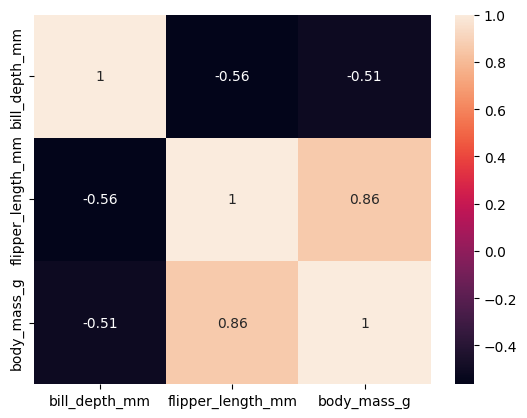

In [ ]:
sns.heatmap(data= penguinstestefinalNumerica_semBillLength.corr(), annot=True)

###3.1.2 KNN (COM BILL LENGTH)
Para imputar o valor de Bill Length, agora sem grandes alterações na base original.

In [ ]:
dfnumerico_teste = penguinstestefinalNumerica_semBillLength.copy()
dfnumerico_teste["bill_length_mm"] = dfnumerico["bill_length_mm"]

In [ ]:
mean = dfnumerico_teste.mean()
std = dfnumerico_teste.std()

threshold_semBillLength = 3

maskh = (dfnumerico_teste > mean + threshold*std) | (dfnumerico_teste < mean - threshold*std)
df_no_outliers_teste = dfnumerico_teste[~mask.any(axis=1)]

In [ ]:
penguinsNumerica = list(dfnumerico_teste.columns)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_no_outliers_teste[penguinsNumerica])
penguinsNorm = scaler.transform(df_no_outliers_teste[penguinsNumerica])

In [ ]:
dfpenguins_teste = pd.DataFrame(penguinsNorm, columns = penguinsNumerica)

In [ ]:
imputer = KNNImputer(n_neighbors=17, weights='distance', copy=True)
imputer.fit(dfpenguins_teste[penguinsNumerica])
dfpenguins_teste[penguinsNumerica] = imputer.transform(dfpenguins_teste[penguinsNumerica])

In [ ]:
penguinsteste = scaler.inverse_transform(dfpenguins_teste[penguinsNumerica])

In [ ]:
penguinstestefinalNumerica = pd.DataFrame(penguinsteste, columns = penguinsNumerica)

##3.2. Plotando:

Fazendo a comparação das mudanças da base após o processo de imputação do KNN.

###3.2.1. HEATMAP

Comparação da correlação das variáveis numéricas, *<b> PRESTAR ATENÇÃO NO POSICIONAMENTO DAS VARIÁVEIS. <b>*

<Axes: >

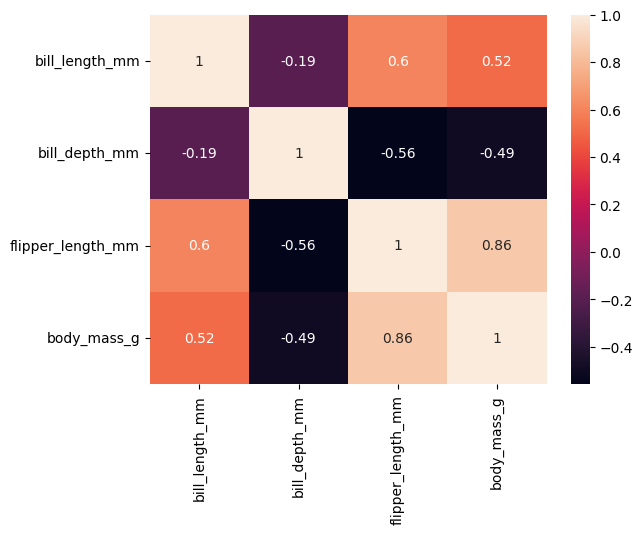

In [ ]:
sns.heatmap(data= df_no_outliers.corr(), annot=True)

<Axes: >

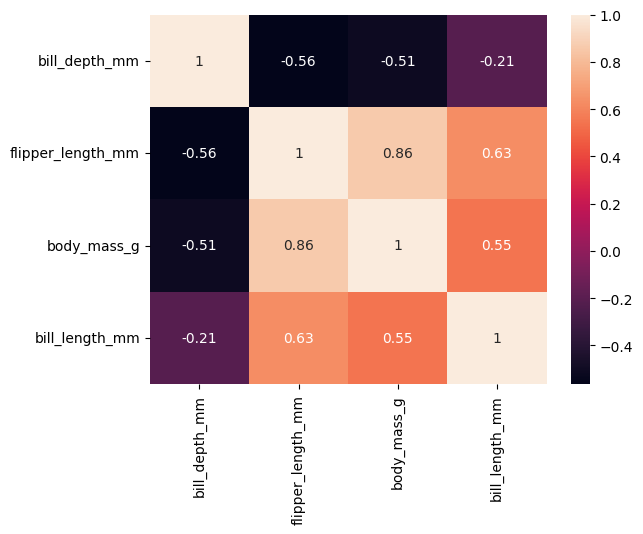

In [ ]:
sns.heatmap(data= penguinstestefinalNumerica.corr(), annot=True)

###3.2.2 PAIRPLOT
Fazendo uma comparação visual de todas as variáveis numéricas <b>*PRESTAR ATENÇÃO NO POSICIONAMENTO DAS VARIÁVEIS*<b>.

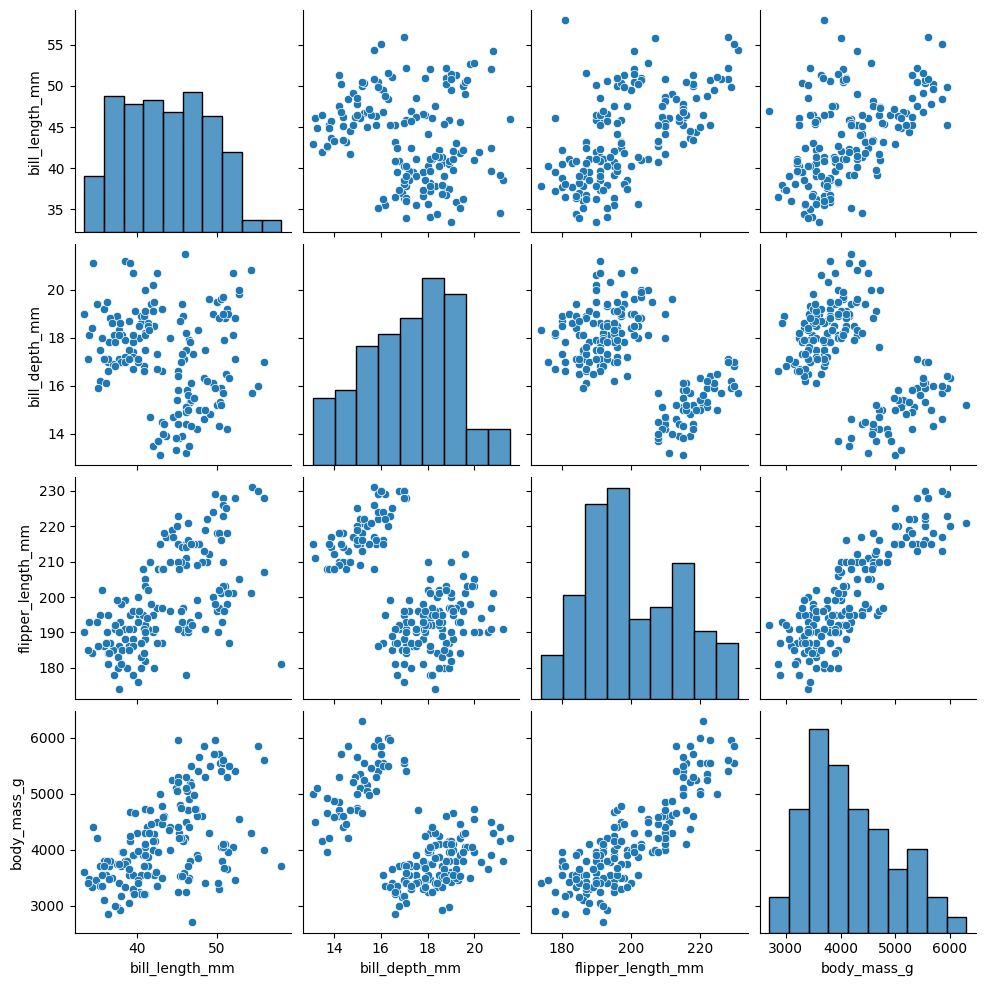

In [ ]:
sns.pairplot(df_no_outliers)
plt.show()

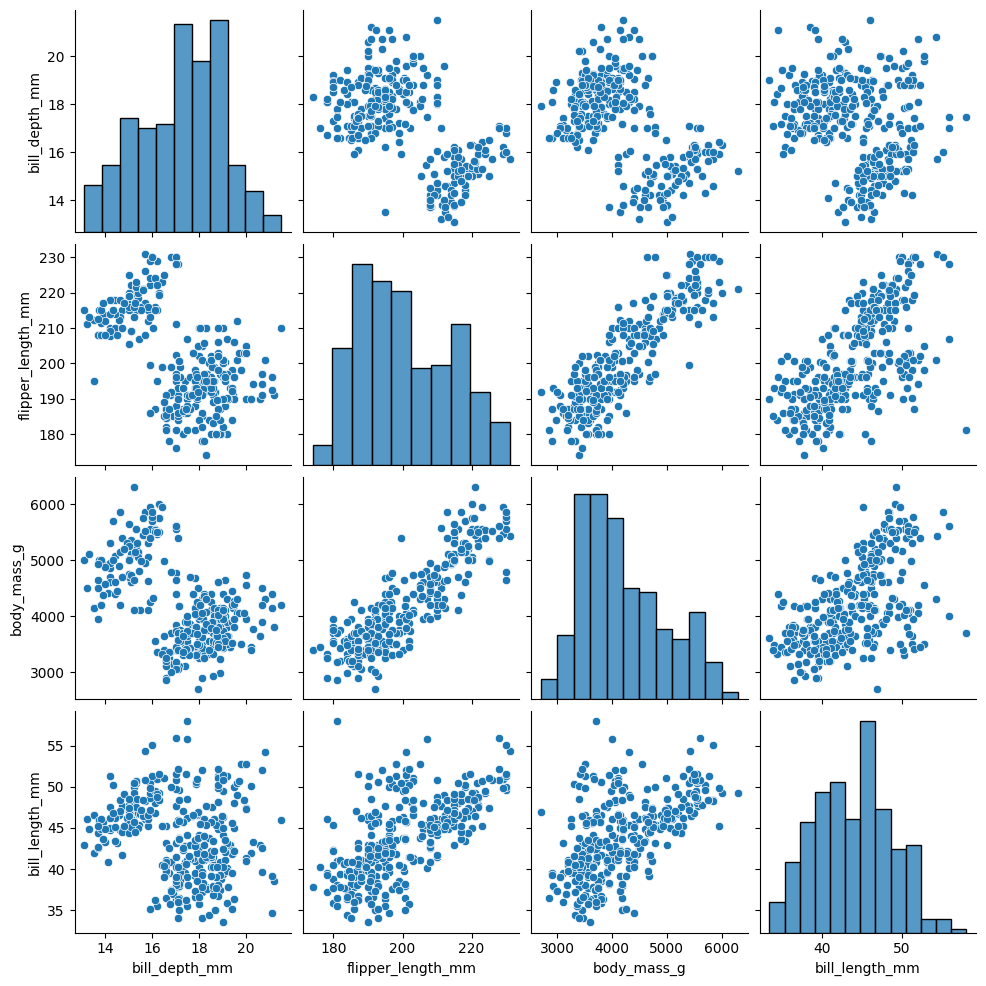

In [ ]:
sns.pairplot(penguinstestefinalNumerica)
plt.show()

#4. Normalização dos dados: <br>
Inicialmente, vamos escalar dos dados num intervalo de 0 a 1, para normalizarmos e podermos correlacioná - los pelo valor.

##4.1. Binning de colunas categóricas:

In [ ]:
binning = dfcategorico
binning = dfcategorico.fillna({'species': 'NaN', 'island': 'NaN', 'sex': 'Nan'}, inplace = True)
binning = pd.get_dummies(dfcategorico, drop_first = False, dtype = int)

<ipython-input-562-f01b4b0e445a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binning = dfcategorico.fillna({'species': 'NaN', 'island': 'NaN', 'sex': 'Nan'}, inplace = True)


In [ ]:
binning

,species_Adelie,species_Chinstrap,species_Gentoo,species_NaN,island_Biscoe,island_Dream,island_NaN,island_Torgersen,sex_Female,sex_Male,sex_Nan
0,1,0,0,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,1,0,1,0,0
2,1,0,0,0,0,0,0,1,1,0,0
3,1,0,0,0,0,0,1,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,1,0,1,0,0,0,0,0,1
340,0,0,1,0,0,0,1,0,0,0,1
341,0,0,0,1,1,0,0,0,0,0,1
342,0,0,1,0,1,0,0,0,1,0,0


Isto fez com que criássemos variáveis separadas onde valores são verdadeiros ou falsos, e para não afetarmos os resultados criando valores NaN, criamos uma coluna para armazenar quais valores são os faltantes.

#5. Imputando Dados Categóricos: <br>
Mas antes de transformá-los apenas em NaN, obtivemos um resultado concreto através das análises iniciais onde:
 - Todos os pinguins da Ilha Torgersen são da espécie Adelie
 - Todos os pinguins da espécie Chinstrap são da ilha Dream
 - Todos os pinguins da espécie Gentoo são da ilha Biscoe <br>
 Com isso podemos imputar valores concretos sem mesmo precisar outros métodos.

Antes de utilizarmos esta análise empírica, iremos fazer uma cópia da tabela a fim de não alterarmos o valor real, evitando assim problemas futuros.

In [ ]:
teste = binning.copy()
teste

,species_Adelie,species_Chinstrap,species_Gentoo,species_NaN,island_Biscoe,island_Dream,island_NaN,island_Torgersen,sex_Female,sex_Male,sex_Nan
0,1,0,0,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,1,0,1,0,0
2,1,0,0,0,0,0,0,1,1,0,0
3,1,0,0,0,0,0,1,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,1,0,1,0,0,0,0,0,1
340,0,0,1,0,0,0,1,0,0,0,1
341,0,0,0,1,1,0,0,0,0,0,1
342,0,0,1,0,1,0,0,0,1,0,0


O código abaixo irá preencher alguns valores que estão faltantes, mas como existem valores 'NaN' que podem atrapalhar esta imputação, ele pode ser rodado novamente mais tarde, a fim de evitar erros de predição, dado que estes valores são regras empíricas baseada nas análises.

In [ ]:
for i in range(len(teste)):
  if teste['island_Torgersen'].tolist()[i] == 1:
    teste['species_Adelie'][i] = 1
    teste['species_NaN'][i] = 0
  if teste['species_Chinstrap'].tolist()[i] == 1:
    teste['island_Dream'][i] = 1
    teste['island_NaN'][i] = 0
  if teste['species_Gentoo'].tolist()[i] == 1:
    teste['island_Biscoe'][i] = 1
    teste['island_NaN'][i] = 0

for i in range(len(teste)):
  if teste['species_NaN'].tolist()[i] == 1:
    teste['species_Adelie'][i] = np.nan
    teste['species_Chinstrap'][i] = np.nan
    teste['species_Gentoo'][i] = np.nan
  if teste['island_NaN'].tolist()[i] == 1:
    teste['island_Biscoe'][i] = np.nan
    teste['island_Dream'][i] = np.nan
    teste['island_Torgersen'][i] = np.nan
  if teste['sex_Nan'].tolist()[i] == 1:
    teste['sex_Female'][i] = np.nan
    teste['sex_Male'][i] = np.nan

teste.drop(['species_NaN', 'island_NaN', 'sex_Nan'], axis = 1, inplace = True)

teste

<ipython-input-565-c4bab43960c5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['species_Chinstrap'][i] = np.nan
<ipython-input-565-c4bab43960c5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['species_Gentoo'][i] = np.nan
<ipython-input-565-c4bab43960c5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['island_Biscoe'][i] = np.nan
<ipython-input-565-c4bab43960c5>:19: SettingWithCopyWarning: 
A value is trying 

,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
339,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN
340,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN
341,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN
342,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


Com alguns valores já preenchidos, iremos resgatar os as colunas numéricas do dataset, para podermos predizer os valores referentes as colunas categóricas utilizando o KNN, e com grande parte do dataset já imputado, os valores de predição e KNN serão bem mais precisos.

In [ ]:
penguinstestefinalNumerica['species_Adelie'] = teste['species_Adelie']
penguinstestefinalNumerica['species_Chinstrap'] = teste['species_Chinstrap']
penguinstestefinalNumerica['species_Gentoo'] = teste['species_Gentoo']
penguinstestefinalNumerica['island_Torgersen'] = teste['island_Torgersen']
penguinstestefinalNumerica['island_Biscoe'] = teste['island_Biscoe']
penguinstestefinalNumerica['island_Dream'] = teste['island_Dream']
penguinstestefinalNumerica['sex_Male'] = teste['sex_Male']
penguinstestefinalNumerica['sex_Female'] = teste['sex_Female']
penguinstestefinalNumerica

,bill_depth_mm,flipper_length_mm,body_mass_g,bill_length_mm,species_Adelie,species_Chinstrap,species_Gentoo,island_Torgersen,island_Biscoe,island_Dream,sex_Male,sex_Female
0,18.700000,180.000000,3750.000000,37.700000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,17.400000,186.000000,3100.000000,39.500000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
2,18.000000,195.000000,3250.000000,40.300000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,17.158197,200.578947,4173.541667,43.640000,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,19.300000,193.000000,3450.000000,42.872429,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
339,17.158197,200.578947,4173.541667,43.640000,0.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN
340,14.300000,215.000000,5000.000000,46.800000,0.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN
341,15.622222,220.769077,5750.000000,48.399629,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN
342,14.800000,217.000002,5200.000000,45.200000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


##5.1. Imputação de Valores nas Colunas Categóricas:

Agora com a tabela completa, ainda precisamos predizer os valores de NaN, com isso, utilizaremos o método de KNN, que a partir de valores vizinhos em outros parâmetros, ele predirá qual é o valor NaN, utilizaremos 17 vizinhos, pois é um número primo, impedindo que a predição dê valores iguais entre as variáveis.

In [ ]:
teste3 = penguinstestefinalNumerica.copy()
imputer = KNNImputer(n_neighbors=17, weights='distance', copy=True)
imputer.fit(teste3)
teste3 = imputer.transform(teste3)

Com a predição feita, iremos visualizar os resultados.

In [ ]:
pd.DataFrame(teste3, columns = list(penguinstestefinalNumerica))

,bill_depth_mm,flipper_length_mm,body_mass_g,bill_length_mm,species_Adelie,species_Chinstrap,species_Gentoo,island_Torgersen,island_Biscoe,island_Dream,sex_Male,sex_Female
0,18.700000,180.000000,3750.000000,37.700000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000
1,17.400000,186.000000,3100.000000,39.500000,0.577198,0.422802,0.0,0.031896,0.008632,0.959472,0.000000,1.000000
2,18.000000,195.000000,3250.000000,40.300000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000
3,17.158197,200.578947,4173.541667,43.640000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
4,19.300000,193.000000,3450.000000,42.872429,1.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.215720,0.784280
...,...,...,...,...,...,...,...,...,...,...,...,...
339,17.158197,200.578947,4173.541667,43.640000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000
340,14.300000,215.000000,5000.000000,46.800000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.126500,0.873500
341,15.622222,220.769077,5750.000000,48.399629,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.997242,0.002758
342,14.800000,217.000002,5200.000000,45.200000,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000


É nítido que os valores não estão perfeitamente separados, pois anteriormente entendia-se que se 'species_Adelie' fosse 1, as outras seriam 0, e isso significaria que a respectiva linha teria como espécie Adelie, mas agora, existem linhas no qual alguns valores não são inteiros, e isso faz parte da predição. Agora iremos arredondar os valores, a fim de fazer com que o maior número entre os itens de uma categoria seja dado como o predito.

Ex: <br> 'species_Adelie' = 0.577198	<br> 'species_Chinstrap' = 0.422802	<br> 'species_Gentoo' = 0.00 <br>

Isso quer dizer que, por mais que sejam números parecidos, tem maior probabilidade, de acordo com a predição, de a espécie ser Adelie.

##5.2. Arredondamento e Finalização:

In [ ]:
for i in range(len(teste3)):
  if teste3[i,4] > teste3[i, 5] and teste3[i,4] > teste3[i, 6]:
    teste3[i, 4] = 1  # Round island_Torgersen
    teste3[i, 5] = 0  # Round island_Dream
    teste3[i, 6] = 0  # Round island_Biscoe
  if teste3[i, 5] > teste3[i,4] and teste3[i,5] > teste3[i, 6]:
    teste3[i, 4] = 0  # Round island_Torgersen
    teste3[i, 5] = 1  # Round island_Dream
    teste3[i, 6] = 0  # Round island_Biscoe
  if teste3[i, 6] > teste3[i,4] and teste3[i,6] > teste3[i, 5]:
    teste3[i, 4] = 0  # Round island_Torgersen
    teste3[i, 5] = 0  # Round island_Dream
    teste3[i, 6] = 1  # Round island_Biscoe
  if teste3[i,7] > teste3[i, 8] and teste3[i,7] > teste3[i, 9]:
    teste3[i, 7] = 1  # Round island_Torgersen
    teste3[i, 8] = 0  # Round island_Dream
    teste3[i, 9] = 0  # Round island_Biscoe
  if teste3[i, 8] > teste3[i,7] and teste3[i,8] > teste3[i, 9]:
    teste3[i, 7] = 0  # Round island_Torgersen
    teste3[i, 8] = 1  # Round island_Dream
    teste3[i, 9] = 0  # Round island_Biscoe
  if teste3[i, 9] > teste3[i,7] and teste3[i,9] > teste3[i, 8]:
    teste3[i, 7] = 0  # Round island_Torgersen
    teste3[i, 8] = 0  # Round island_Dream
    teste3[i, 9] = 1  # Round island_Biscoe
  teste3[i, 10] = teste3[i, 10].round(0)  # Round sex_Female
  teste3[i, 11] = teste3[i, 11].round(0)  # Round Sex_Male

teste3 = pd.DataFrame(teste3, columns = list(penguinstestefinalNumerica))
teste3

,bill_depth_mm,flipper_length_mm,body_mass_g,bill_length_mm,species_Adelie,species_Chinstrap,species_Gentoo,island_Torgersen,island_Biscoe,island_Dream,sex_Male,sex_Female
0,18.700000,180.000000,3750.000000,37.700000,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,17.400000,186.000000,3100.000000,39.500000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,18.000000,195.000000,3250.000000,40.300000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,17.158197,200.578947,4173.541667,43.640000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,19.300000,193.000000,3450.000000,42.872429,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
339,17.158197,200.578947,4173.541667,43.640000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
340,14.300000,215.000000,5000.000000,46.800000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
341,15.622222,220.769077,5750.000000,48.399629,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
342,14.800000,217.000002,5200.000000,45.200000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


Crio novas colunas, pois iremos 'desfazer' o Get Dummies, mas agora com os valores já definidos

In [ ]:
teste3['species'] = dfcategorico['species']
teste3['island'] = dfcategorico['island']
teste3['sex'] = dfcategorico['sex']

O Código abaixo desfaz o Get Dummies, transformando os valores de 0 e 1 para seus respectivos nomes, juntando as três colunas de espécies em uma só, bem como ilha e sexo

In [ ]:
for i in range(len(teste3)):
  if teste3['species_Adelie'].tolist()[i] == 1:
    teste3['species'][i] = 'Adelie'
  if teste3['species_Chinstrap'].tolist()[i] == 1:
    teste3['species'][i] = 'Chinstrap'
  if teste3['species_Gentoo'].tolist()[i] == 1:
    teste3['species'][i] = 'Gentoo'
  if teste3['island_Biscoe'].tolist()[i] == 1:
    teste3['island'][i] = 'Biscoe'
  if teste3['island_Dream'].tolist()[i] == 1:
    teste3['island'][i] = 'Dream'
  if teste3['island_Torgersen'].tolist()[i] == 1:
    teste3['island'][i] = 'Torgersen'
  if teste3['sex_Female'].tolist()[i] == 1:
    teste3['sex'][i] = 'Female'
  if teste3['sex_Male'].tolist()[i] == 1:
    teste3['sex'][i] = 'Male'

Streaming output truncated to the last 5000 lines.
<ipython-input-571-47d95fd11106>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste3['sex'][i] = 'Female'
<ipython-input-571-47d95fd11106>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste3['species'][i] = 'Adelie'
<ipython-input-571-47d95fd11106>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste3['island'][i] = 'Dream'
<ipython-input-571-47d95fd11106>:15: SettingWithCo

Agora excluimos as colunas que não utilizaremos mais

In [ ]:
teste3.drop(['species_Adelie', 'species_Chinstrap', 'species_Gentoo', 'island_Torgersen', 'island_Dream', 'island_Biscoe', 'sex_Female', 'sex_Male'], axis = 1, inplace = True)
#teste3.drop([])
teste3

,bill_depth_mm,flipper_length_mm,body_mass_g,bill_length_mm,species,island,sex
0,18.700000,180.000000,3750.000000,37.700000,Adelie,Torgersen,Male
1,17.400000,186.000000,3100.000000,39.500000,Adelie,Dream,Female
2,18.000000,195.000000,3250.000000,40.300000,Adelie,Torgersen,Female
3,17.158197,200.578947,4173.541667,43.640000,Adelie,Biscoe,Female
4,19.300000,193.000000,3450.000000,42.872429,Adelie,Dream,Female
...,...,...,...,...,...,...,...
339,17.158197,200.578947,4173.541667,43.640000,Gentoo,Biscoe,Female
340,14.300000,215.000000,5000.000000,46.800000,Gentoo,Biscoe,Female
341,15.622222,220.769077,5750.000000,48.399629,Gentoo,Biscoe,Male
342,14.800000,217.000002,5200.000000,45.200000,Gentoo,Biscoe,Female


A fim de evitar problemas, iremos separar o dataframe por espécies, e retirar os outlies de cada espécie, para evitar confusões.

In [ ]:
especie = teste3.groupby('species')

adelie = especie.get_group('Adelie')
gentoo = especie.get_group('Gentoo')
chinstrap = especie.get_group('Chinstrap')

adelie

,bill_depth_mm,flipper_length_mm,body_mass_g,bill_length_mm,species,island,sex
0,18.700000,180.000000,3750.000000,37.700000,Adelie,Torgersen,Male
1,17.400000,186.000000,3100.000000,39.500000,Adelie,Dream,Female
2,18.000000,195.000000,3250.000000,40.300000,Adelie,Torgersen,Female
3,17.158197,200.578947,4173.541667,43.640000,Adelie,Biscoe,Female
4,19.300000,193.000000,3450.000000,42.872429,Adelie,Dream,Female
...,...,...,...,...,...,...,...
214,18.766667,189.500000,3650.000000,40.268939,Adelie,Dream,Female
225,13.500000,212.264304,4150.000000,46.500000,Adelie,Biscoe,Female
236,13.500000,195.000000,4150.000000,42.000000,Adelie,Biscoe,Female
262,18.300000,210.000000,4300.000000,45.300000,Adelie,Biscoe,Female


In [ ]:
adelie.drop(['species', 'island', 'sex'], axis = 1, inplace = True)
mean = adelie.mean()
std = adelie.std()
threshold = 3
mask = (adelie > mean + threshold*std) | (adelie < mean - threshold*std)
adelie_ = adelie[~mask.any(axis=1)]

gentoo.drop(['species', 'island', 'sex'], axis = 1, inplace = True)
mean = gentoo.mean()
std = gentoo.std()
threshold = 3
mask = (gentoo > mean + threshold*std) | (gentoo < mean - threshold*std)
gentoo_ = gentoo[~mask.any(axis=1)]

chinstrap.drop(['species', 'island', 'sex'], axis = 1, inplace = True)
mean = chinstrap.mean()
std = chinstrap.std()
threshold = 3
mask = (chinstrap > mean + threshold*std) | (chinstrap < mean - threshold*std)
chinstrap_ = chinstrap[~mask.any(axis=1)]

<ipython-input-574-73a579d0555c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adelie.drop(['species', 'island', 'sex'], axis = 1, inplace = True)
<ipython-input-574-73a579d0555c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gentoo.drop(['species', 'island', 'sex'], axis = 1, inplace = True)
<ipython-input-574-73a579d0555c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chinstrap.drop(['species', 'island', 'sex'], axis = 1, i

De acordo com as análises, apenas os pinguins de espécie Adelie teve muitos outlies, iremos retirar as linhas com os outliers de espécie Adelie.

In [ ]:
teste3.drop([95, 121, 183, 189, 225, 236], axis = 0, inplace = True)


In [ ]:
penguinsImput = teste3.copy()

#6. Conclusão:

Com os valores preditos, agora deveremos analisar os resultados e comparar com a tabela inicial que tinha os valores faltantes, a fim de verificar se mesmo com diversos valores imputados, a tabela ainda segue o mesmo padrão.

##6.1. DataFrame Imputado:

Abaixo iremos visualizar o novo DataFrame, com os valores já imputados.

In [ ]:
penguinsImput

,bill_depth_mm,flipper_length_mm,body_mass_g,bill_length_mm,species,island,sex
0,18.700000,180.000000,3750.000000,37.700000,Adelie,Torgersen,Male
1,17.400000,186.000000,3100.000000,39.500000,Adelie,Dream,Female
2,18.000000,195.000000,3250.000000,40.300000,Adelie,Torgersen,Female
3,17.158197,200.578947,4173.541667,43.640000,Adelie,Biscoe,Female
4,19.300000,193.000000,3450.000000,42.872429,Adelie,Dream,Female
...,...,...,...,...,...,...,...
339,17.158197,200.578947,4173.541667,43.640000,Gentoo,Biscoe,Female
340,14.300000,215.000000,5000.000000,46.800000,Gentoo,Biscoe,Female
341,15.622222,220.769077,5750.000000,48.399629,Gentoo,Biscoe,Male
342,14.800000,217.000002,5200.000000,45.200000,Gentoo,Biscoe,Female


##6.2. Pairplots:

Plotamos um pairplot com a base nova e um com a base inicial. <b> AO ANALISAR, VERIFICAR A RESPECTIVA POSIÇÃO DAS COLUNAS, POIS ELAS ESTÃO EM ORDEM DIFERENTE. </b>

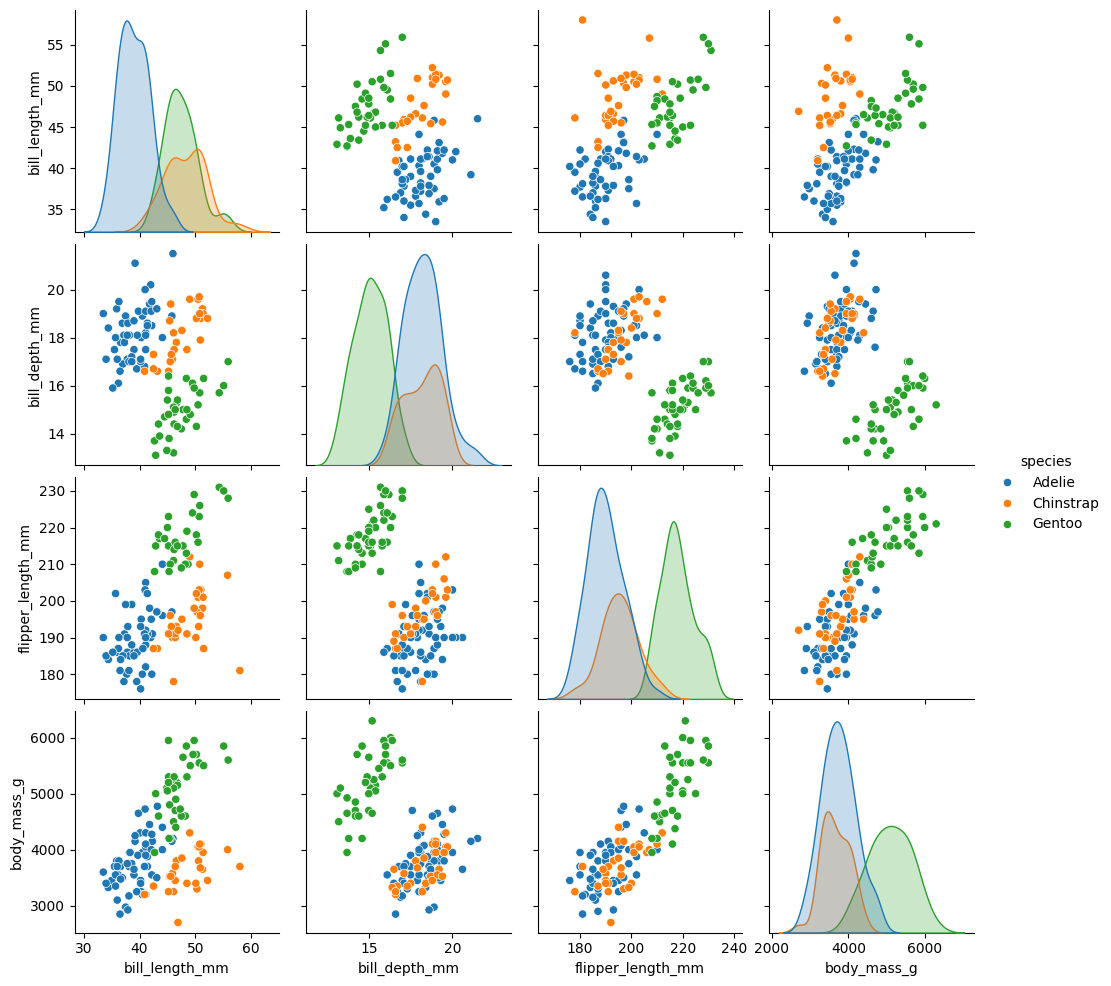

In [ ]:
sns.pairplot(penguins, hue = 'species')

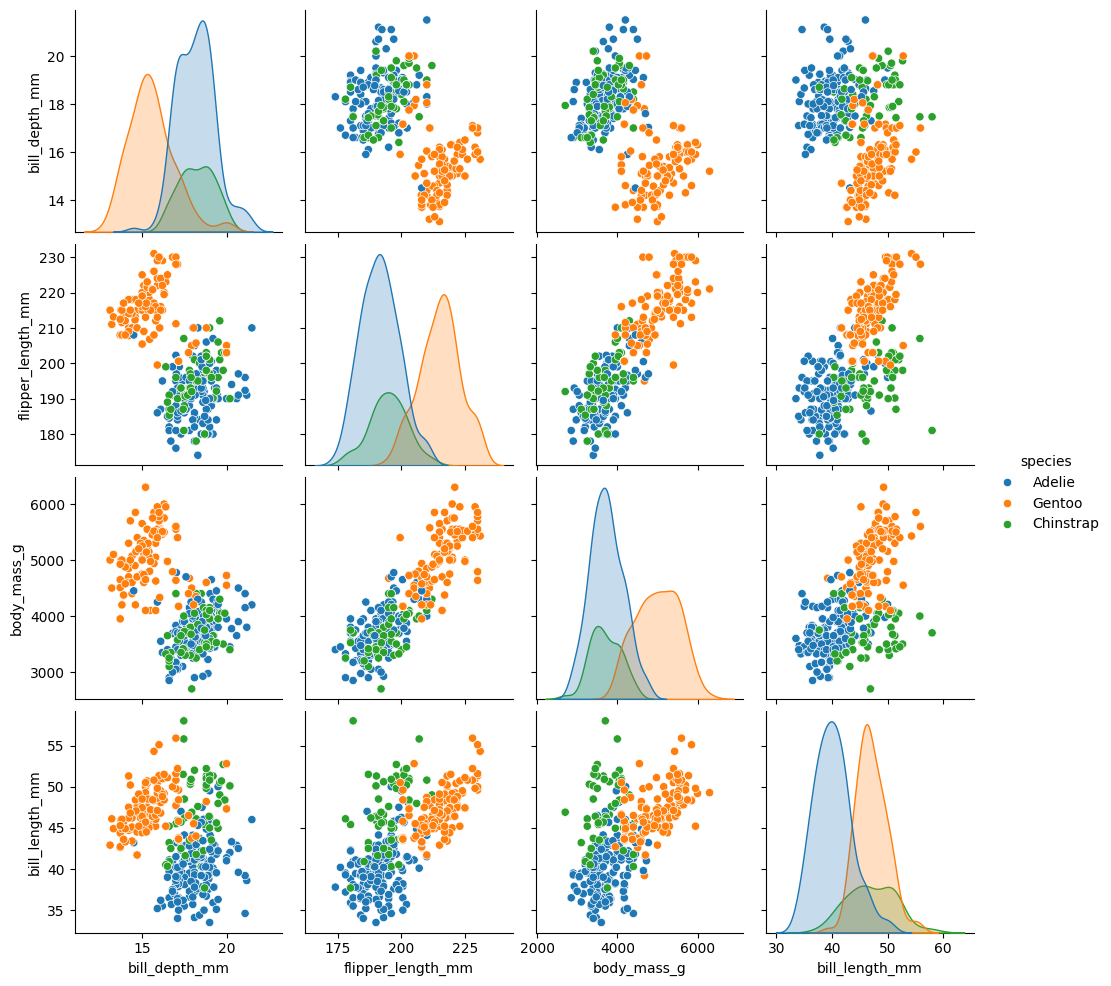

In [ ]:
sns.pairplot(teste3, hue = 'species')